# Calibration of a 2 theta arm with a Pilatus 100k detector

The aim of this document is to explain how to use pyFAI.goniometer for calibrating the position of the detector from the goniometer encoders.

Those data have been acquired at ROBL (ESRF-BM20 German CRG) in winter 2017 by Christoph Henning using a Pilatus 100k detector and LaB6 as calibrant. One hundred and twenty one images have been acquired with the detector moving between 5 and 65 degree with a step size of half a degree. The motor position is registered in the filename.

A prior manual calibration (using pyFAI-calib) has been performed on four images locate at 31.5, 33.5, 35 and 35.5 degrees. Those images were the first with two rings. The control points extrated during this initial calibration has been used as a starting point for this calibration. Then more images have been added to make the model more robust.

The raw data files are available at: http://www.silx.org/pub/pyFAI/gonio/Pilatus-100k-LaB6/

## Initialization and loading of the libraries

Initialization of the plotting library, matplotlib, to be used with the jupyter notebook

In [1]:
%matplotlib inline
# %matplotlib nbagg
import numpy
from matplotlib.pyplot import subplots
import time, pyFAI
start_time = time.perf_counter()
print("Using pyFAI version", pyFAI.version)

Using pyFAI version 0.20.0-beta1


In [2]:
#Download all images

import os
from silx.resources import ExternalResources

#Nota: This may be useful if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"

downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages", "PYFAI_DATA")
all_files = downloader.getdir("LaB6_gonio_BM20.tar.bz2")
print([os.path.basename(i) for i in all_files])


['LaB6_gonio_BM20', 'del_45.0_0001p.cbf', 'del_08.5_0001p.cbf', 'del_20.5_0001p.cbf', 'minimum-mask.edf', 'del_09.0_0001p.cbf', 'del_53.0_0001p.cbf', 'del_60.0_0001p.cbf', 'del_63.5_0001p.cbf', 'del_56.5_0001p.cbf', 'del_12.5_0001p.cbf', 'del_53.5_0001p.cbf', 'del_42.5_0001p.cbf', 'del_16.5_0001p.cbf', 'del_05.5_0001p.cbf', 'del_47.0_0001p.cbf', 'del_39.0_0001p.cbf', 'del_47.5_0001p.cbf', 'del_57.0_0001p.cbf', 'del_35.5_0001p.poni', 'del_07.5_0001p.cbf', 'del_41.5_0001p.cbf', 'del_51.0_0001p.cbf', 'del_33.0_0001p.cbf', 'del_22.0_0001p.cbf', 'del_43.5_0001p.cbf', 'del_64.5_0001p.cbf', 'del_35.0_0001p.cbf', 'del_13.5_0001p.cbf', 'del_08.0_0001p.cbf', 'del_29.0_0001p.cbf', 'del_45.5_0001p.cbf', 'del_63.0_0001p.cbf', 'del_61.5_0001p.cbf', 'del_31.5_0001p.npt', 'del_11.0_0001p.cbf', 'del_46.5_0001p.cbf', 'del_11.5_0001p.cbf', 'del_56.0_0001p.cbf', 'del_18.0_0001p.cbf', 'del_06.5_0001p.cbf', 'del_46.0_0001p.cbf', 'del_58.5_0001p.cbf', 'del_35.5_0001p.npt', 'del_30.0_0001p.cbf', 'del_15.5_000

In [3]:
#Loading of a few libraries

import os
import random
import fabio
import pyFAI
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

## Display of an image and its headers

List of images: del_05.0_0001p.cbf, del_05.5_0001p.cbf, del_06.0_0001p.cbf, del_06.5_0001p.cbf, del_07.0_0001p.cbf, del_07.5_0001p.cbf, del_08.0_0001p.cbf, del_08.5_0001p.cbf, del_09.0_0001p.cbf, del_09.5_0001p.cbf, del_10.0_0001p.cbf, del_10.5_0001p.cbf, del_11.0_0001p.cbf, del_11.5_0001p.cbf, del_12.0_0001p.cbf, del_12.5_0001p.cbf, del_13.0_0001p.cbf, del_13.5_0001p.cbf, del_14.0_0001p.cbf, del_14.5_0001p.cbf, del_15.0_0001p.cbf, del_15.5_0001p.cbf, del_16.0_0001p.cbf, del_16.5_0001p.cbf, del_17.0_0001p.cbf, del_17.5_0001p.cbf, del_18.0_0001p.cbf, del_18.5_0001p.cbf, del_19.0_0001p.cbf, del_19.5_0001p.cbf, del_20.0_0001p.cbf, del_20.5_0001p.cbf, del_21.0_0001p.cbf, del_21.5_0001p.cbf, del_22.0_0001p.cbf, del_22.5_0001p.cbf, del_23.0_0001p.cbf, del_23.5_0001p.cbf, del_24.0_0001p.cbf, del_24.5_0001p.cbf, del_25.0_0001p.cbf, del_25.5_0001p.cbf, del_26.0_0001p.cbf, del_26.5_0001p.cbf, del_27.0_0001p.cbf, del_27.5_0001p.cbf, del_28.0_0001p.cbf, del_28.5_0001p.cbf, del_29.0_0001p.cbf, del_

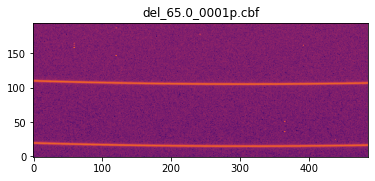

In [4]:
#loading of the list of files, and display of the last one with its headers

image_files = [i for i in all_files if i.endswith(".cbf")]
image_files.sort()
print("List of images: " + ", ".join([os.path.basename(i) for i in image_files]) + "." + os.linesep)
fimg = fabio.open(image_files[-1])

print("Image headers:")
for key, value in  fimg.header.items():
    print("%s: %s"%(key,value))
    
jupyter.display(fimg.data, label=os.path.basename(fimg.filename))
pass

## Definition of the geometry transformation

This is the most difficult part to understand.

The next cell defines 2 functions, one for transforming the geometry and the other one to read the goniometer angle from the metadata

In [5]:
#Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis, i.e. rot2

goniotrans = GeometryTransformation(param_names = ["dist", "poni1", "poni2", "rot1",
                                                   "rot2_offset", "rot2_scale"],
                                    dist_expr="dist", 
                                    poni1_expr="poni1",
                                    poni2_expr="poni2", 
                                    rot1_expr="rot1", 
                                    rot2_expr="rot2_scale * pos + rot2_offset", 
                                    rot3_expr="0.0")


#Definition of the function reading the goniometer angle from the filename of the image.

def get_angle(basename):
    """Takes the basename (like del_65.0_0001p ) and returns the angle of the detector"""
    return float(os.path.basename((basename.split("_")[1])))

basename = os.path.basename(fimg.filename)
print('filename', basename, "angle:",get_angle(basename))

filename del_65.0_0001p.cbf angle: 65.0


In [6]:
#Definition of the detector, its mask, the calibrant
mask_files = [i for i in all_files if i.endswith("-mask.edf")]
mask = numpy.logical_or(fabio.open(mask_files[0]).data, fabio.open(mask_files[1]).data)
pilatus = pyFAI.detector_factory("Pilatus100k")
pilatus.mask = mask
    
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
wavelength = 7.7490120575e-11
LaB6.wavelength = wavelength

In [7]:
#Definition of the geometry refinement: the parameter order is the same as the param_names
epsilon = numpy.finfo(numpy.float32).eps
param = {"dist":0.8, 
         "poni1":0.02, 
         "poni2":0.04, 
         "rot1":0,
         "rot2_offset":0,
         "rot2_scale": numpy.pi/180. # rot2 is in radians, while the motor position is in degrees
        }
#Defines the bounds for some variables
bounds = {"dist": (0.79, 0.81), 
          "rot1": (-0.01, 0.01),
          "rot2_offset": (-0.01, 0.01),
          "rot2_scale": (numpy.pi/180.-epsilon, numpy.pi/180.+epsilon) #strict bounds on the scale: we expect the gonio to be precise
         }
gonioref = GoniometerRefinement(param, #initial guess
                                bounds=bounds,
                                pos_function=get_angle,
                                trans_function=goniotrans,
                                detector=pilatus, wavelength=wavelength)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [8]:
#Let's populate the goniometer refinement object with all control point files:

ponis = [i for i in all_files if i.endswith(".poni")]
ponis.sort()
for fn in ponis:
    base = os.path.splitext(fn)[0]
    basename = os.path.basename(base)
    fimg = fabio.open(base + ".cbf")
    sg =gonioref.new_geometry(basename, image=fimg.data, metadata=basename, control_points=base+".npt",
                              geometry=fn, calibrant=LaB6)
    print(sg.label, "Angle:", sg.get_position())
    print(sg.geometry_refinement)
    print()
    

print("Filled refinement object:")
print(gonioref)


# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:58:02.580029
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 C
# Lakeshore 0.00 K
# Detector: PILATUS 2M 24-0111
# Silicon sensor, thickness 0.00045 m
# Pixel_size 0.000172 m x 0.000172 m
# Exposure_time 9.9977 s
# Exposure_period 9

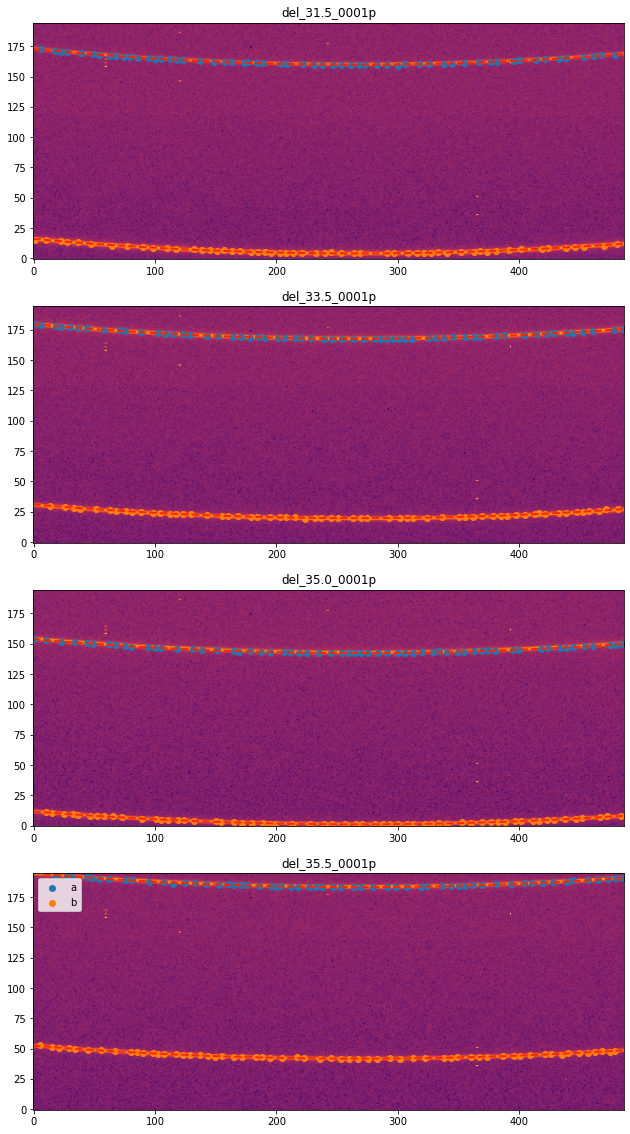

In [9]:
#Display all images with associated calibration:
nimg = len(gonioref.single_geometries)
fig,ax = subplots(nimg, 1, figsize=(20,nimg*5))
for i, sg in enumerate(gonioref.single_geometries.values()):
    jupyter.display(sg=sg, ax=ax[i])
pass

In [10]:
# Initial refinement of the goniometer model with 5 dof
gonioref.refine2()

Cost function before refinement: 4.6762802794818724e-05
[0.8        0.02       0.04       0.         0.         0.01745329]
     fun: 3.473034229473271e-09
     jac: array([ 1.55799982e-08,  6.20957747e-08, -8.86843207e-09,  9.37828842e-09,
        4.54540993e-08, -2.83664178e-05])
 message: 'Optimization terminated successfully'
    nfev: 127
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.80587908,  0.01626749,  0.04374863, -0.00299852, -0.00217975,
        0.01745341])
Cost function after refinement: 3.473034229473271e-09
GonioParam(dist=0.8058790848800199, poni1=0.0162674931897931, poni2=0.04374863086696927, rot1=-0.002998518469094807, rot2_offset=-0.0021797516602028453, rot2_scale=0.017453411729232846)
maxdelta on: dist (0) 0.8 --> 0.8058790848800199


array([ 0.80587908,  0.01626749,  0.04374863, -0.00299852, -0.00217975,
        0.01745341])

In [11]:
# This function adds new images to the pool of data used for the refinement.
# A set of new control points are extractred and a refinement step is performed at each iteration
# The last image of the serie is displayed 

def optimize_with_new_images(list_images, pts_per_deg=1):
    sg = None
    for fname in list_images:
        print()
        basename = os.path.basename(fname)
        base = os.path.splitext(basename)[0]
        fimg = fabio.open(fname)
        if base in gonioref.single_geometries:
            continue
        print(base)
        sg = gonioref.new_geometry(base, image=fimg.data, metadata=base,
                                   calibrant=LaB6)
        print(sg.extract_cp(pts_per_deg=pts_per_deg))
    print("*"*50)
    gonioref.refine2()
    if sg: 
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
        jupyter.display(sg=sg)



# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:58:33.361867
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 C
# Lakeshore 0.00 K
# Detector: PILATUS 2M 24-0111
# Silicon sensor, thickness 0.00045 m
# Pixel_size 0.000172 m x 0.000172 m
# Exposure_time 9.9977 s
# Exposure_period 

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
# f ring 9: 36 points
# g ring 10: 30 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:00:40.645355
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperat

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# k ring 6: 36 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:59:06.546917
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# s ring 7: 36 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:01:41.982449
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

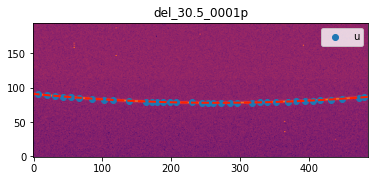

In [12]:
# Append all other images bewteen 30 and 40 degrees

images_30_40 = [i for i in all_files if ("del_3" in i and i.endswith("0001p.cbf"))]
random.shuffle(images_30_40)
optimize_with_new_images(images_30_40, pts_per_deg=3)


# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:00:40.700773
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 C
# Lakeshore 0.00 K
# Detector: PILATUS 2M 24-0111
# Silicon sensor, thickness 0.00045 m
# Pixel_size 0.000172 m x 0.000172 m
# Exposure_time 9.9977 s
# Exposure_period 

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
# z ring 20: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:03:16.919311
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 0 groups of points:

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:11:56.968950
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 C
# Lakeshore 0.00 K


ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#ak ring 6: 7 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:01:11.369300
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#ao ring 15: 10 points
#ap ring 16: 9 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:03:49.393539
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperat

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#ax ring 26: 8 points
#ay ring 27: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:52:51.449325
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperatu

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#bd ring 4: 16 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:10:23.107378
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#bm ring 24: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:47:07.379855
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#bq ring 0: 30 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:47:07.895049
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#bv ring 0: 11 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:06:20.898004
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#ca ring 4: 11 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:07:21.138279
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#cf ring 18: 8 points
#cg ring 19: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:56:28.921493
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperatu

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#ck ring 24: 8 points
#cl ring 25: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:52:19.395986
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperatu

ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 0 groups of points:

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:07:51.740210
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 C
# Lakeshore 0.00 K


ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 0 groups of points:

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:53:52.155580
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0 C
# Lakeshore 0.00 K


ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#da ring 3: 17 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:12:27.101423
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#di ring 12: 10 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:46:36.167174
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#dp ring 1: 24 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T18:03:16.948608
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#dv ring 25: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:52:19.446852
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.0

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 1 groups of points:
#dy ring 12: 10 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:54:26.138958
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperature 0.00 K
# Blower 0.

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 97 reflections at wavelength 7.7490120575e-11
Containing 2 groups of points:
#eb ring 22: 8 points
#ec ring 23: 8 points

# Detector: PILATUS 2M, 24-0111
# 2016-05-17T17:58:32.868105
# Pixel_size 172e-6 m x 172e-6 m
# Silicon sensor, thickness 0.000450 m
# Exposure_time 9.9977 s
# Exposure_period 9.9977 s
# Tau = 1.991e-07 s
# Count_cutoff 1071182 counts
# Threshold_setting: 4024.0 eV
# Gain_setting: low gain (vrf = -0.300)
# N_excluded_pixels = 1
# Excluded_pixels: badpix_mask.tif
# Flat_field: FF_p2m0111_E26000_T13000_vrf_m0p30.tif
# Trim_file: p2m0111_E26000_T13000_vrf_m0p30.bin
# Image_path: /ramdisk/
# Wavelength 0.7749 A
# Start_angle 0.00 deg.
# Angle_increment 0.00 deg.
# Omega 0.00 deg.
# Omega_increment 0.00 deg.
# Phi 0.00 deg.
# Phi_increment 0.00 deg.
# Kappa 0.0 deg.
# Oscillation_axis PHI
# Detector_distance 0.157 m
# Detector_Voffset 0.0 m
# Beam_xy (542.41, 732.4) pixels
# Flux 0 counts
# Temperatu

/usr/lib/python3/dist-packages/pyFAI/gui/jupyter.py:79: UserWarning: No contour levels were found within the data range.
  ax.contour(ttha, levels=tth, cmap="autumn", linewidths=2, linestyles="dashed")


     fun: 1.2414040557448947e-08
     jac: array([-4.44688063e-08,  1.00231909e-06, -2.02577827e-08,  1.05803497e-08,
        8.09666953e-07, -9.25612549e-04])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 0.8058814 ,  0.0162719 ,  0.04328121, -0.00262068, -0.0021759 ,
        0.01745341])
Cost function after refinement: 1.2414040557448947e-08
GonioParam(dist=0.8058813979197966, poni1=0.01627189950015672, poni2=0.04328120973866541, rot1=-0.0026206837097791915, rot2_offset=-0.002175895268095377, rot2_scale=0.017453411729232846)
maxdelta on: poni2 (2) 0.04374867383258055 --> 0.04328120973866541


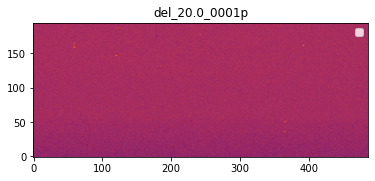

In [13]:
# Append all other images

all_images = [i for i in all_files if i.endswith(".cbf")]
random.shuffle(all_images)
optimize_with_new_images(all_images)

First & last rings
Total number of images: 121


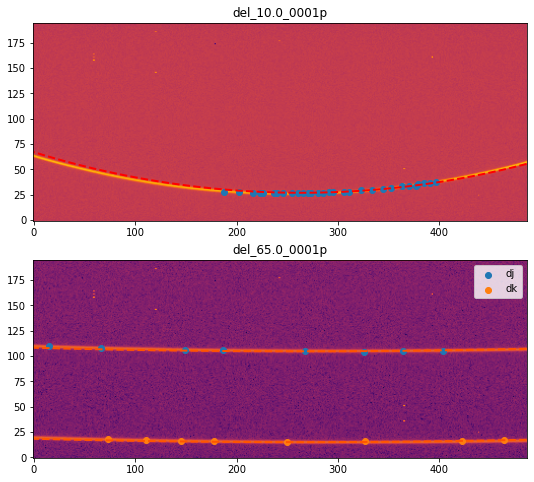

In [14]:
# Check the calibration of the first and the last image with rings

print("First & last rings")

print("Total number of images:", len(gonioref.single_geometries) )

fig,ax  = subplots(2, 1, figsize=(20,8))
for idx,lbl in enumerate(["del_10.0_0001p", "del_65.0_0001p"]):
    sg = gonioref.single_geometries[lbl]
    if sg.control_points.get_labels():
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=ax[idx])

In [15]:
# Final pass of refinement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine2("slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)

Cost function before refinement: 1.2414040557448947e-08
[ 0.8058814   0.0162719   0.04328121 -0.00262068 -0.0021759   0.01745341]
     fun: 1.1201428917916492e-08
     jac: array([ 6.84361876e-08, -9.89309304e-09,  5.37037353e-07, -4.40259184e-07,
       -5.62483551e-09, -2.50305180e-08])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.80588143,  0.01622651,  0.04328057, -0.00262015, -0.00221247,
        0.01745601])
Cost function after refinement: 1.1201428917916492e-08
GonioParam(dist=0.8058814330950826, poni1=0.016226509518190272, poni2=0.04328056976869554, rot1=-0.002620154555017879, rot2_offset=-0.0022124664981937373, rot2_scale=0.017456012555286927)
maxdelta on: poni1 (1) 0.01627189950015672 --> 0.016226509518190272


array([ 0.80588143,  0.01622651,  0.04328057, -0.00262015, -0.00221247,
        0.01745601])

In [16]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)
    
multigeo = gonioref.get_mg(angles)
multigeo.radial_range=(4, 66)
print(multigeo)

MultiGeometry integrator with 121 geometries on (4, 66) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


In [17]:
# Calculate the optimal number of point for integration
over = 1
npt = int(over * numpy.deg2rad(max(multigeo.radial_range) - min(multigeo.radial_range)) / 
          numpy.arctan2(pilatus.pixel1, gonioref.nt_param(*gonioref.param).dist))
print("Number of bins: %s"%npt)

Number of bins: 5070


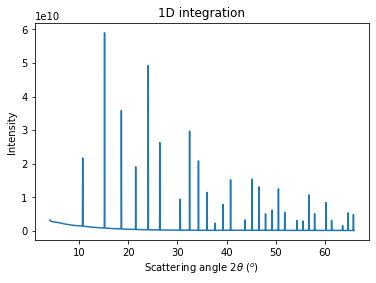

In [18]:
# Integrate the whole set of images in a single run:

res = multigeo.integrate1d(images, npt)
jupyter.plot1d(res)
pass

In [19]:
# Save the goniometer configuration with 1 angle

gonioref.save("ROBL_v1.json")

In [20]:
#Can the refinement be improved by freeing another degree of freedom ? what about rot1 ?

goniotrans2 = GeometryTransformation(param_names = ["dist", "poni1", "poni2", 
                                                    "rot1", "rot1_scale",
                                                    "rot2_offset", "rot2_scale"],
                                     dist_expr="dist", 
                                     poni1_expr="poni1",
                                     poni2_expr="poni2", 
                                     rot1_expr="rot1_scale * pos + rot1", 
                                     rot2_expr="rot2_scale * pos + rot2_offset", 
                                     rot3_expr="0.0")

param2 = (gonioref.nt_param(*gonioref.param))._asdict()
param2["rot1_scale"] = 0

gonioref2 = GoniometerRefinement(param2, 
                                 pos_function = get_angle,
                                 trans_function=goniotrans2,
                                 detector=pilatus,
                                 wavelength=wavelength)
gonioref2.single_geometries = gonioref.single_geometries.copy()

print(gonioref2.chi2(), gonioref.chi2())
gonioref2.refine2()
gonioref2.save("ROBL_v2.json")

1.1201428917916492e-08 1.1201428917916492e-08
Cost function before refinement: 1.1201428917916492e-08
[ 0.80588143  0.01622651  0.04328057 -0.00262015  0.         -0.00221247
  0.01745601]
     fun: 4.784268978670502e-09
     jac: array([ 4.83580818e-08, -1.22536698e-07, -7.04560715e-09,  6.03399075e-09,
        1.99023001e-08, -1.01915002e-07, -4.04191697e-06])
 message: 'Optimization terminated successfully'
    nfev: 108
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 8.05856713e-01,  1.62114876e-02,  4.17434732e-02, -1.37737776e-03,
       -1.29828173e-04, -2.22389622e-03,  1.74564328e-02])
Cost function after refinement: 4.784268978670502e-09
GonioParam(dist=0.8058567125358187, poni1=0.01621148755332537, poni2=0.04174347321241412, rot1=-0.001377377760925881, rot1_scale=-0.00012982817291904377, rot2_offset=-0.002223896221623935, rot2_scale=0.017456432797639122)
maxdelta on: poni2 (2) 0.04328056976869554 --> 0.04174347321241412


First & last rings


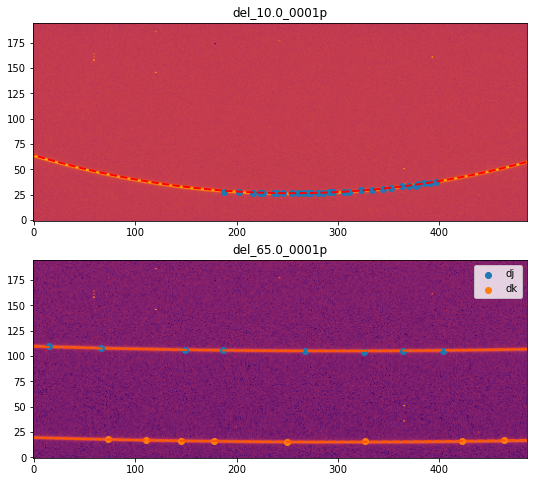

In [21]:
# Check the calibration of the first and the last image with rings

print("First & last rings")

fig,ax = subplots(2, 1, figsize=(10,8))
for idx,lbl in enumerate(["del_10.0_0001p", "del_65.0_0001p"]):
    sg = gonioref.single_geometries[lbl]
    if sg.control_points.get_labels():
        sg.geometry_refinement.set_param(gonioref2.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=ax[idx])

MultiGeometry integrator with 121 geometries on (4, 66) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


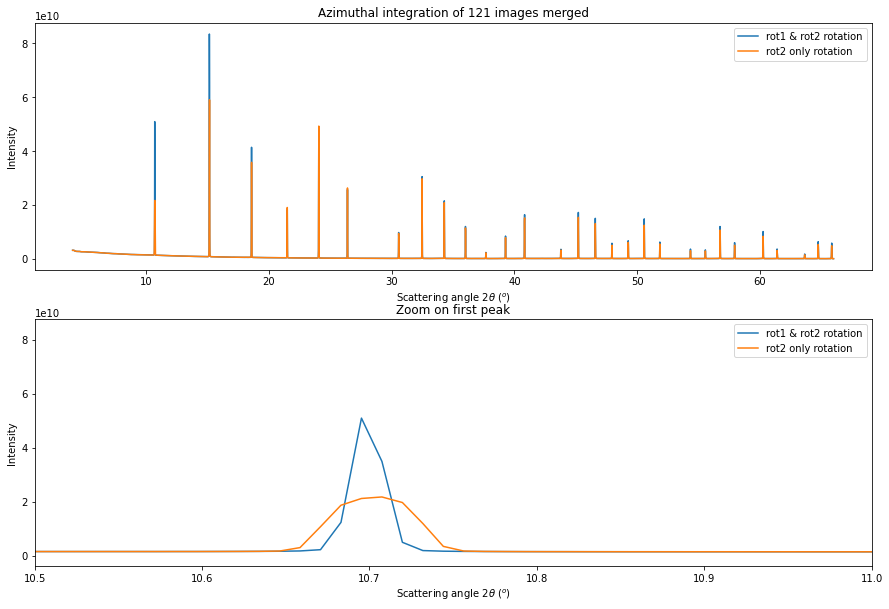

In [22]:
#Create a MultiGeometry integrator from the refined geometry and display the integrated image:

multigeo2 = gonioref2.get_mg(angles)
multigeo2.radial_range=(4, 66)
print(multigeo2)

res2 = multigeo2.integrate1d(images, npt)

#Display the 2 curves with a zoom
fig,ax = subplots(2, 1, figsize=(15,10))
ax[0].plot(*res2, label="rot1 & rot2 rotation")
ax[0].plot(*res, label="rot2 only rotation")
ax[0].set_xlabel(res.unit.label)
ax[0].set_ylabel("Intensity")
ax[0].set_title("Azimuthal integration of 121 images merged")
ax[0].legend()

ax[1].plot(*res2, label="rot1 & rot2 rotation")
ax[1].plot(*res, label="rot2 only rotation")
ax[1].set_xlabel(res.unit.label)
ax[1].set_ylabel("Intensity")
ax[1].set_xlim(10.5,11)
ax[1].set_title("Zoom on first peak")
ax[1].legend()
pass

With the first model, the refinement was not perfect on the very low angles and indicates a miss-fit. Relaxing the constrains on *rot1* allowed to spot a non (perfect) orthogonality between the goniometer axis and the incident beam. Releasing the distances is also possible, for example to cope with the sample not perfectly mounted on the center of the goniometer. 

## Evaluation of the peak-profile

For every peak, as listed in the calibrant's definition, the peak height can be extracted and the nearest minimum evaluated. The the full width at half maximum can be measured an ploted as function of the scattering angle. 
The FWHM can be fitted against Caglioti's formula: 

FWHM² = U tan² $\theta$ + V tan $\theta$ + W

In [23]:
# Line profile function...
#Peak profile

from scipy.interpolate import interp1d
from scipy.optimize import bisect

def calc_fwhm(integrate_result, calibrant):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=integrate_result.radial[0]) or (tth_deg>=integrate_result.radial[-1]):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]

        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        tth_lo = bisect(f, min_lo, tth_maxi)
        tth_hi = bisect(f, tth_maxi, min_hi)
        FWHM.append(tth_hi-tth_lo)
        tth.append(tth_deg)
    return tth, FWHM


In [24]:
#Fit against Caglioti's formula:
# FWHM^2 = Utan2 + Vtan + W
tth_deg, FWHM_deg = calc_fwhm(res2, LaB6)

def model_Caglioti(tth_deg, U, V, W):
    tantheta = numpy.tan(numpy.deg2rad(tth_deg)/2.0)
    FWHM2 = U*tantheta*tantheta + V*tantheta + W
    return numpy.rad2deg(numpy.sqrt(FWHM2))

from scipy.optimize import curve_fit
fit,cov = curve_fit(model_Caglioti, tth_deg, FWHM_deg, p0=[1e-6,1e-7,1e-8])
print(fit)
print(cov)

[ 2.17390968e-07 -4.91366782e-08  1.69257348e-07]
[[ 4.04651222e-14 -3.04640275e-14  4.75794383e-15]
 [-3.04640275e-14  2.39007253e-14 -3.95477893e-15]
 [ 4.75794383e-15 -3.95477893e-15  7.26507512e-16]]


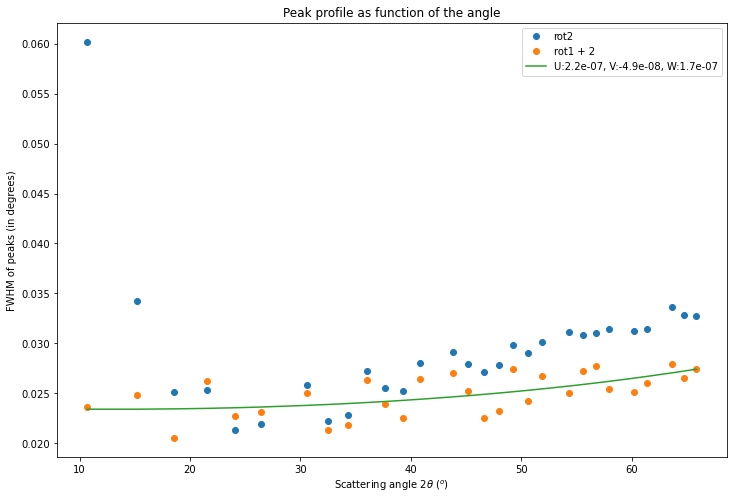

In [25]:
fig, ax = subplots(figsize=(12,8))
ax.plot(*calc_fwhm(res, LaB6), "o", label="rot2")
ax.plot(*calc_fwhm(res2, LaB6), "o", label="rot1 + 2")
# for lbl, sg in gonioref2d.single_geometries.items():
#     ai = gonioref2d.get_ai(sg.get_position())
#     img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
#     res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
#     t,w = calc_fwhm(res, calibrant=calibrant)
#     ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak profile as function of the angle")
ax.set_ylabel("FWHM of peaks (in degrees)")
ax.set_xlabel(res.unit.label)
ax.plot(tth_deg, model_Caglioti(tth_deg, *fit), label="U:%.1e, V:%.1e, W:%.1e"%(fit[0], fit[1], fit[2]))
ax.legend()
pass

## Conclusion

This notebook exposes the how to calibrate the goniometer for a small detector moving on a 2theta arm. 
Once calibrated, the geometry can be saved and restored and stays valid as long as the detector or the goniometer is not unmounted from the beam-line. This configuration can subsequently be used to integrate the data acquired with any  sample, in minutes instead of hours. The resolution limit is now the pixel size. Fortunately, pixel detector with small pixel like the MaxiPix or the Lambda detector exists and offer higher resolution.

In [26]:
print(f"Total execution time: {time.perf_counter() - start_time:.3f} s")

Total execution time: 31.152 s
